# MITRotor Quickstart

`MITRotor` is used for setting up and solving customizable blade element models (BEMs). These models can either be solved on their own, or used within the `MITWindfarm` package to explore various wind farm dynamics. `MITRotor` allows the user to specify rotor definition, geometry, aerodynamic properties, tip loss method, axial induction calculation method, and tangential induction calculation method.

The two most important classes for a user are the `BEM` class and the `BEMSolution` class. The `BEM` class allows the user to build a BEM, which then calculates a `BEMSolution` when given the arguments `pitch`, `tsr`, and `yaw`. We will start this tutorial with initializing a `BEM` object.

Start with installing the code from GitHub. In order to run the notebook below, you will need to install `MITRotor`. Then import the code as follows:

In [15]:
import MITRotor as mr

We also need a few common python packages.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

## Initializing a `BEM` Object

### Rotor Definitions
The first argument needed to initialize a `BEM` is a `RotorDefinition`. A `RotorDefinition` is a separate class that allows the user to define many of the rotor properties. The most straightforward way to create a new rotor definition is to create a `.yaml` file with each of the necessary fields, just like the files in the `ReferenceTurbines` folder. These files can then be read in using the `from_windio` function, which returns a `RotorDefinition`.

This process is streamlined for the three provided reference turbines: `IEA15MW`, `IEA10MW`, and `IEA3_4MW`. For these three turbines, the user simply needs to call the function names with no arguments and a `RotorDefinition` using the previously mentioned `yaml` files will be created. These files were originally accessed through the [IEA Wind Systems GitHub repository](https://github.com/IEAWindSystems).

In [17]:
rotor_15mw = mr.IEA15MW()
rotor_10mw = mr.IEA10MW()

If you want to create a new turbine type, see the example files in the `ReferenceTurbines` folder and the code in the `RotorDefinitions.py` file to start building your own definition beyond the reference turbines.

### Geometry

For the `BEM` model geometry, the user can choose how many points they would like radially and azimuthally. The default, if no geometry is provided to the `BEM` constructor, is 10 points radially and 20 points azimuthally. If the user wants a coarser or finer simulation, they can provide the arguments `Nr` and `Ntheta`. 

In [18]:
rotor_geometry = mr.BEMGeometry(Nr = 100, Ntheta = 30)

### Tip Loss Model

There are two options for tip loss models, `NoTipLoss` and `PrandtlTipLoss`, which are concrete subtypes of the `TipLossModel` class. As the names suggest, the `NoTipLoss` model does not model tip loss, while the `PrandtlTipLoss` uses Prandtl's tip loss factor. With `PrandtlTipLoss`, there is an optional `root_loss` parameter, which defaults to `True`.

If no tip loss model is provided to the `BEM`, the default is the `PrandtlTipLoss` with `root_loss` set to true.

In [19]:
no_tip_loss = mr.NoTipLoss()
prandtl_tip_loss = mr.PrandtlTipLoss(root_loss = True)

### Momentum Model

There are 5 total momentum models to the user to choose from, all of which are concrete subtypes of the `MomentumModel` class. The options are: `ConstantInduction`, `ClassicalMomentum`, `HeckMomentum`, `UnifiedMomentum`, and `MadsenMomentum`. Each of these different momentum models requires different arguments. These are as follows:

- `ConstantInduction`: argument `a`, which is the constant induction for the rotor. The default is $\frac{1}{3}$.

- `ClassicalMomentum`: no arguments.

- `HeckMomentum`: arguments `averaging` and `ac`. The options for `averaging` are: `"sector"`, `"annulus"`, or `"rotor"` (with a default of `"rotor"`). The default value of `ac`, the initial induction value, is $\frac{1}{3}$ [[Heck et al., 2023](https://doi.org/10.1017/jfm.2023.129)]. 

- `UnifiedMomentum`: arguments `averaging` and `beta`. The argument `averaging` has the same options as for the `HeckMomentum` model. The argument `beta` is the shear layer growth rate parameter and has a default value of 0.1403 [[Liew et al., 2024](https://www.nature.com/articles/s41467-024-50756-5)].

- `MadsenMomentum`: argument `cosine_exponent`, which is an optional exponent on the cosine term in the Madsen model [[Madsen et al., 2020](https://wes.copernicus.org/articles/5/1/2020/)].

The `HeckMomentum` model with default arguments is provided to the `BEM` as the momentum model if the user doesn't provide one.

Here we show an example of the `UnifiedMomentum` model:

In [20]:
unified_momentum_model = mr.UnifiedMomentum(averaging = "rotor")

### Tangential Induction Model

There are two options for the tangential induction model, `NoTangentialInduction` and `DefaultTangentialInduction`, which are concrete subtypes of the `TangentialInductionModel` class. Neither takes any arguments, and as the name suggests, the `DefaultTangentialInduction` is the default model provided to the `BEM`.

In [21]:
tangential_induction_model = mr.DefaultTangentialInduction()

### Aerodynamic Model

There are two options for aerodynamic models, `KraghAerodynamics` and `DefaultAerodynamics`, both of which are concrete subtypes of the `AerodynamicModel` class. They do not take any arguments, and are called internally to get the needed `AerodynamicProperties` for our calculations. As the name suggests, `DefaultAerodynamics` is the default for the BEM unless otherwise specified. The `KraghAerodynamics` class is based off the model in the 2012 paper: [Load alleviation of wind turbines by yaw misalignment](https://doi.org/10.1002/we.1612).

In [22]:
default_aerodynamic_model = mr.DefaultAerodynamics()
kragh_aerodynamic_model = mr.KraghAerodynamics()

### BEM Model

At this point, we can use all of the previously defined objects to create our `BEM`.

In [23]:
bem_model = mr.BEM(
    rotor = rotor_15mw,
    geometry = rotor_geometry,
    tiploss_model = prandtl_tip_loss,
    momentum_model = unified_momentum_model,
    tangential_induction_model = tangential_induction_model,
    aerodynamic_model = default_aerodynamic_model
)

## BEM Solutions

Now that we have defined a BEM model, we can solve for a `BEMSolution`. You can pass `pitch`, tip speed ratio (`tsr`), and `yaw` to the `BEM` model. This call will return a `BEMSolution`. Here we examine the solution for BEM created above with $0^\circ$ pitch, a value of 7 for the tip speed ratio, and $20^\circ$ yaw. For more information on what information can be retrieved from a `BEMSolution`, see the `BEMSolver.py` file.

In [24]:
pitch, tsr, yaw = np.deg2rad(0), 7.0, np.deg2rad(20.0)
sol = bem_model(pitch, tsr, yaw)

# Print various quantities in BEM solution
if sol.converged:
    print(f"BEM solution converged in {sol.niter} iterations.")
else:
    print("BEM solution did NOT converge!")

print(f"Control setpoints: {sol.pitch=:2.2f}, {sol.tsr=:2.2f}, {sol.yaw=:2.2f}")
print(f"Power coefficient: {sol.Cp():2.2f}")
print(f"Thrust coefficient: {sol.Ct():2.2f}")
print(f"Local thrust coefficient: {sol.Ctprime():2.2f}")
print(f"Axial induction: {sol.a():2.2f}")
print(f"Rotor-effective windspeed: {sol.U():2.2f}")
print(f"Far-wake streamwise velocity: {sol.u4():2.2f}")
print(f"Far-wake lateral velocity: {sol.v4():2.2f}")


BEM solution converged in 29 iterations.
Control setpoints: sol.pitch=0.00, sol.tsr=7.00, sol.yaw=0.35
Power coefficient: 0.42
Thrust coefficient: 0.63
Local thrust coefficient: 1.12
Axial induction: 0.20
Rotor-effective windspeed: 1.00
Far-wake streamwise velocity: 0.60
Far-wake lateral velocity: -0.05


Now that we know that the BEM solution converged, we can look at the values of `C_p`, `C_T`, and `a_n` radially over the rotor.

(0.0, 1.0)

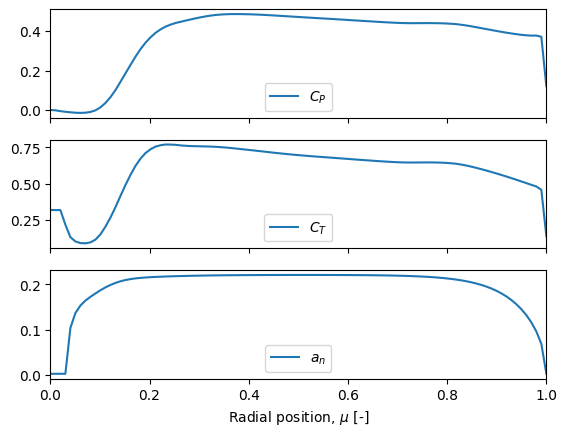

In [25]:
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(sol.geom.mu, sol.Cp(grid="annulus"), label="$C_P$")
axes[1].plot(sol.geom.mu, sol.Ct(grid="annulus"), label="$C_T$")
axes[2].plot(sol.geom.mu, sol.a(grid="annulus"), label="$a_n$")

[ax.legend(loc="lower center") for ax in axes]
axes[-1].set_xlabel("Radial position, $\mu$ [-]")
plt.xlim(0, 1)

If you're looking for a more exploratory script, see `example_03_pitch_tsr_contour.py`. If you're looking to run a simulation with multiple turbines in a wind farm configuration, see the quick start guide for `MITWindfarm`.